# Region-scale glacier analysis


The previous notebook demonstrated using xarray to analyze surface velocity data for an individual glacier. This notebook will show how we can examine spatial variability in surface velocity within a group of glaciers. To do this we will use **xarray** as well as **geopandas**, **geocube**, and **pandas**. We will start by using `.make_geocube()` to rasterize a vector object in the shape of an **ITS_LIVE** velocity raster object. We will then use the rasterized vector to group the **ITS_LIVE** object by individual glaciers and then calculate summary statistics of surface velocity for each glacier. The goal in this work flow is to end up with a **pandas dataframe** where each row is an individual glacier and columns for various surface velocity summary statistics. 

*Learning goals:*
- rasterizing vector data
- organizing and re-arranging data with xarray
- `.groupby()` for zonal statistics
- converting from xarray to pandas

In [1]:
import os
import json
import urllib.request
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
#import matplotlib.ticker as mticker

from shapely.geometry import Polygon
from shapely.geometry import Point
#import cartopy.crs as ccrs
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import cartopy
#import cartopy.feature as cfeature

from geocube.api.core import make_geocube

%config InlineBackend.figure_format='retina'

In [2]:
import itslivetools

## Accessing ITS_LIVE data

In [4]:
itslive_catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

In [7]:
url = itslivetools.find_granule_by_point([95.180191, 30.645973])
url

'http://its-live-data.s3.amazonaws.com/datacubes/v2/N30E090/ITS_LIVE_vel_EPSG32646_G0120_X750000_Y3350000.zarr'

In [9]:
dc = itslivetools.read_in_s3(url)
dc

<xarray.Dataset>
Dimensions:                     (mid_date: 25243, y: 833, x: 833)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2022-06-07T04:21:44...
  * x                           (x) float64 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

The `mid_date` dimension of the `dc` object isn't in chronlogical order, so let's sort by this dimension:

In [10]:
dc = dc.sortby('mid_date')

Create a `crs` object based on the `projection` data variable of the data cube (`dc`) object.

In [11]:
crs = f'EPSG:{dc.projection}'
crs

'EPSG:32646'

## Vector data 

In [12]:
#se_asia = gpd.read_file('https://github.com/e-marshall/itslive/raw/master/rgi15_southasiaeast.geojson')
se_asia = gpd.read_file('/home/emmamarshall/Desktop/data/rgi/south_asia_east_15/15_rgi60_SouthAsiaEast.shp')
se_asia.head(3)

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00186,G099434E30654N,20020113,-9999999,99.433808,30.653638,15,3,7.214,4802,...,20,4777,0,0,0,0,9,9,NaN,"POLYGON ((99.43677 30.66915, 99.43710 30.66871..."
1,RGI60-15.00234,G097476E28353N,20000927,-9999999,97.475654,28.352548,15,3,8.507,4372,...,304,5000,0,0,0,0,9,9,NaN,"POLYGON ((97.48622 28.33782, 97.48571 28.33832..."
2,RGI60-15.00368,G098674E28425N,20011203,-9999999,98.674072,28.425392,15,3,8.219,3165,...,200,8634,0,0,0,0,9,9,NaN,"POLYGON ((98.69611 28.43341, 98.69679 28.43155..."


How many glaciers are in this dataframe?

In [13]:
se_asia['RGIId'].nunique()

524

What coordinate reference system is this dataframe in? 

In [14]:
se_asia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The vector dataset is in WGS 84, meaning that its coordinates are in degrees latitude and longitude rather than meters N and E. We will project this dataset to match the projection of the netcdf dataset.

## Handling projections

Let's project this dataframe to match the CRS of the itslive dataset

In [15]:
#project rgi data to match itslive
se_asia_prj = se_asia.to_crs(crs) #we know the epsg from the projection variable of the dc object
se_asia_prj.head(3)

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-15.00186,G099434E30654N,20020113,-9999999,99.433808,30.653638,15,3,7.214,4802,...,20,4777,0,0,0,0,9,9,NaN,"POLYGON ((1117230.262 3410667.898, 1117265.509..."
1,RGI60-15.00234,G097476E28353N,20000927,-9999999,97.475654,28.352548,15,3,8.507,4372,...,304,5000,0,0,0,0,9,9,NaN,"POLYGON ((939962.250 3142812.410, 939909.404 3..."
2,RGI60-15.00368,G098674E28425N,20011203,-9999999,98.674072,28.425392,15,3,8.219,3165,...,200,8634,0,0,0,0,9,9,NaN,"POLYGON ((1058304.715 3158456.550, 1058381.685..."


Give each glacier (row) a unique integer key that is related to that glacier's RGIId. We will use this later. Be careful that the `RGI_int` column is composed of **integers** not strings.

In [16]:
se_asia_prj['RGI_int'] = se_asia_prj['RGIId'].str.slice(9,).replace('.','_')
se_asia_prj['RGI_int'] = se_asia_prj.RGI_int.apply(lambda x: int('15' + x))
se_asia_prj.RGI_int.dtype

dtype('int64')

To start with, we will look only at glaciers larger in area than 5km2. Subset the dataset to select for those glaciers

In [17]:
se_asia_prj = se_asia_prj.loc[se_asia_prj['Area'] > 5.]
se_asia_prj.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int
0,RGI60-15.00186,G099434E30654N,20020113,-9999999,99.433808,30.653638,15,3,7.214,4802,...,4777,0,0,0,0,9,9,NaN,"POLYGON ((1117230.262 3410667.898, 1117265.509...",1500186
1,RGI60-15.00234,G097476E28353N,20000927,-9999999,97.475654,28.352548,15,3,8.507,4372,...,5000,0,0,0,0,9,9,NaN,"POLYGON ((939962.250 3142812.410, 939909.404 3...",1500234
2,RGI60-15.00368,G098674E28425N,20011203,-9999999,98.674072,28.425392,15,3,8.219,3165,...,8634,0,0,0,0,9,9,NaN,"POLYGON ((1058304.715 3158456.550, 1058381.685...",1500368
3,RGI60-15.00406,G098182E28652N,20011203,-9999999,98.181747,28.651985,15,3,7.800,4544,...,5205,0,0,0,0,9,9,NaN,"POLYGON ((1009141.937 3177946.948, 1009112.063...",1500406
4,RGI60-15.00503,G098653E28454N,20011203,-9999999,98.652981,28.453739,15,3,7.006,3917,...,9013,0,0,0,0,9,9,NaN,"POLYGON ((1055479.016 3162736.584, 1055469.623...",1500503


Next, want to subset the RGI dataset by the spatial extent of the ITS_LIVE data.
First, get the bbox of the ITS_LIVE data as a vector

In [20]:
#def get_bbox_single(input_xr, epsg = input_xr.projection):
def get_bbox_single(input_xr, epsg):

    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

    #print(input_xr.mapping.spatial_epsg)
    #print(f"epsg:{input_xr.mapping.spatial_epsg}")
    crs = epsg
    #crs = {'init':f'epsg:{input_xr.mapping.spatial_epsg}'}
    #crs = 'epsg:32645'
    #print(crs)

    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    #polygon = polygon.to_crs('epsg:4326')

    #bounds = polygon.total_bounds
    #bounds_format = [bounds[0]-15, bounds[2]+15, bounds[1]-15, bounds[3]+15]

    #states_provinces = cfeature.NaturalEarthFeature(
    #    category = 'cultural',
    #    name = 'admin_1_states_provinces_lines',
    #    scale='50m',
    #    facecolor='none'
    #)
    return polygon

In [21]:
dc_bbox = get_bbox_single(dc, crs)

In [23]:
dc_bbox.crs

<Projected CRS: EPSG:32646>
Name: WGS 84 / UTM zone 46N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 90°E and 96°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. Indonesia. Mongolia. Myanmar (Burma). Russian Federation.
- bounds: (90.0, 0.0, 96.0, 84.0)
Coordinate Operation:
- name: UTM zone 46N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Project it to local UTM to match the RGI geodataframe and extract the coordinate values from the geometry column

## Rasterize vector

Subset RGI dataset:
To do this we will use a [spatial join](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html). Here we use an `inner join` but there are various methods to customize the spatial join operation. Find more info [here](https://geopandas.org/en/stable/gallery/spatial_joins.html). 

In [24]:
rgi_sub = gpd.sjoin(se_asia_prj, dc_bbox, how='inner')
# need to set the type as string here bc for some reason its object intead of str
rgi_sub["RGIId"] = rgi_sub.RGIId.astype("string")
rgi_sub.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,RGI_int,index_right
5,RGI60-15.00621,G095088E30322N,19990923,-9999999,95.088364,30.321632,15,3,45.973,3432,...,0,0,0,0,9,9,NaN,"POLYGON ((704603.054 3353787.635, 704618.934 3...",1500621,0
6,RGI60-15.00639,G095180E30646N,19990923,-9999999,95.180191,30.645973,15,3,8.688,4744,...,0,0,0,0,9,9,NaN,"POLYGON ((709916.300 3391462.613, 709882.915 3...",1500639,0
7,RGI60-15.00642,G095206E30632N,19990923,-9999999,95.205750,30.631853,15,3,6.801,4697,...,0,0,0,0,9,9,NaN,"POLYGON ((712314.578 3391472.930, 712355.266 3...",1500642,0
8,RGI60-15.00655,G095323E30633N,19990923,-9999999,95.323348,30.633339,15,3,5.284,4979,...,0,0,0,0,9,9,NaN,"POLYGON ((724381.841 3390545.667, 724380.953 3...",1500655,0
9,RGI60-15.00835,G095642E30308N,19990923,-9999999,95.642175,30.308182,15,3,5.747,4454,...,0,0,0,0,9,9,NaN,"POLYGON ((756119.478 3353815.541, 756063.500 3...",1500835,0


Write crs of dc object:

In [25]:
dc = dc.rio.write_crs(crs)

In [26]:
rgi_sub = rgi_sub.drop('index_right', axis=1)

In [27]:
len(rgi_sub['RGIId']) # number of glaciers in the subset

27

Now, use the `.make_geocube()` function. This essentially takes a vector object (`rgi_sub`) and rasterizes it, returning an xarray object with the same structure as the object you provide for the `like =` argument (in our case that is `dc`). This example relies greatly on the [zonal statistics example](https://corteva.github.io/geocube/html/examples/zonal_statistics.html) in the **geocube** documentation, which contains additional helpful details. 

In [28]:
dc

<xarray.Dataset>
Dimensions:                     (mid_date: 25243, y: 833, x: 833)
Coordinates:
    mapping                     int64 0
  * mid_date                    (mid_date) datetime64[ns] 1986-09-11T03:31:15...
  * x                           (x) float64 7.001e+05 7.003e+05 ... 8e+05
  * y                           (y) float64 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(25243, 30, 30), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(25243,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(25243,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [29]:
out_grid = make_geocube(
    vector_data = rgi_sub,
    measurements = ["RGI_int"],
    like = dc
)
out_grid

<xarray.Dataset>
Dimensions:      (y: 833, x: 833)
Coordinates:
  * y            (y) float64 3.4e+06 3.4e+06 3.4e+06 ... 3.3e+06 3.3e+06 3.3e+06
  * x            (x) float64 7.001e+05 7.003e+05 7.004e+05 ... 7.999e+05 8e+05
    spatial_ref  int64 0
Data variables:
    RGI_int      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

Now each glacier in the geodataframe `rgi_sub` has been coded with a unique integer value that corresponds to that glacier's Randolph Glacier Inventory ID. 

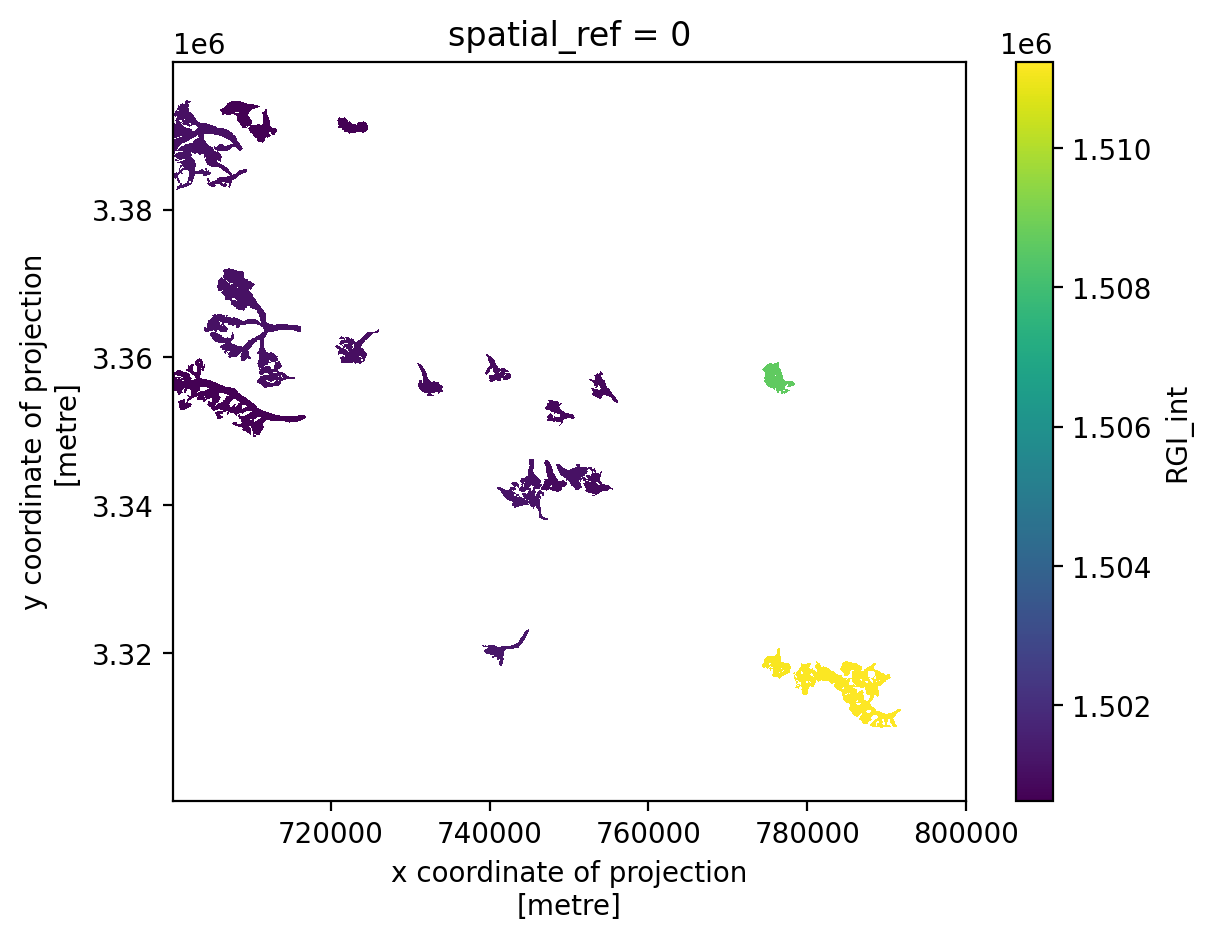

In [30]:
out_grid.RGI_int.plot();

Before moving forward, we will take a temporal subset of the full dataset to make it a bit easier to work with. Then, merge the rasterized vector and the dataset containing the velocity data into an xarray dataset:

In [36]:
dc_sub = dc.isel(mid_date=slice(0,100))

In [37]:
dc_sub.v.dims

('mid_date', 'y', 'x')

In [ ]:
dc_sub.v.values

In [32]:
out_grid['v'] = (dc_sub.v.dims, dc_sub.v.values, dc_sub.v.attrs, dc_sub.v.encoding)
                # out_grid["elevation"] = (elevation.dims, elevation.values, elevation.attrs, elevation.encoding)

KeyboardInterrupt: 

Assign the `RGI_int` object as a `coordinate variable` of the `xarray.Dataset` rather than a `data_var`. 

In [61]:
out_grid = out_grid.assign_coords({'RGI_int':out_grid.RGI_int})

Now, we will use `.groupby()` to group the dataset by the RGI ID:

In [67]:
grouped_ID = out_grid.groupby('RGI_int')

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


and compute summary statistics for a single variable on the grouped object:

In [127]:
grid_mean_sp = grouped_ID.mean(dim=...).rename({'v': 'speed_mean'})
grid_median_sp = grouped_ID.median(dim=...).rename({'v': 'speed_median'})
grid_max_sp = grouped_ID.max(dim=...).rename({'v': 'speed_max'})
    

Check if the data arrays (`RGI_int`) are equal, must be the case for `xr.merge()` in next step

In [128]:
print(grid_mean_sp.RGI_int.equals(grid_min_sp.RGI_int))
print(grid_mean_sp.RGI_int.equals(grid_max_sp.RGI_int))
print(grid_min_sp.RGI_int.equals(grid_max_sp.RGI_int))

True
True
True


Merge and convert the lazy object to an in-memory equivalent usind dask [`.compute()`](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.compute.html). Once it is in-memory, we can convert it to a pandas dataframe.

In [129]:
zonal_stats = xr.merge([grid_mean_sp, grid_median_sp, grid_max_sp]).compute()


In [130]:
zonal_stats_df = zonal_stats.to_dataframe()

In [131]:
zonal_stats_df = zonal_stats_df.reset_index()

In [132]:
zonal_stats_df = zonal_stats_df.drop(['spatial_ref'], axis=1)
zonal_stats_df

,RGI_int,speed_mean,speed_median,speed_max
0,1500621.0,41.962807,19.0,469.0
1,1500639.0,22.150459,12.0,373.0
2,1500642.0,19.307652,10.0,394.0
3,1500655.0,14.125192,7.0,260.0
4,1500835.0,11.500683,6.0,227.0
5,1500850.0,18.467958,8.0,439.0
6,1500872.0,16.736874,8.0,363.0
7,1500885.0,31.812437,11.0,398.0
8,1500898.0,27.027910,16.0,320.0
9,1500899.0,16.742266,8.0,239.0


Now, make a new object (`rgi_itslive`) where you merge the zonal stats dataframe onto the GeoPandas.GeoDataframe object containing the RGI glacier outlines. 

In [133]:
rgi_itslive = rgi_sub.loc[rgi_sub['Area'] > 5.]

In [172]:
rgi_itslive = pd.merge(rgi_sub, right =  zonal_stats_df, how='inner', on='RGI_int')

In [173]:
rgi_itslive['RGIId'].nunique()

27

## Data visualization
Now we can start to visualize the prepared dataset:

### Pandas plotting

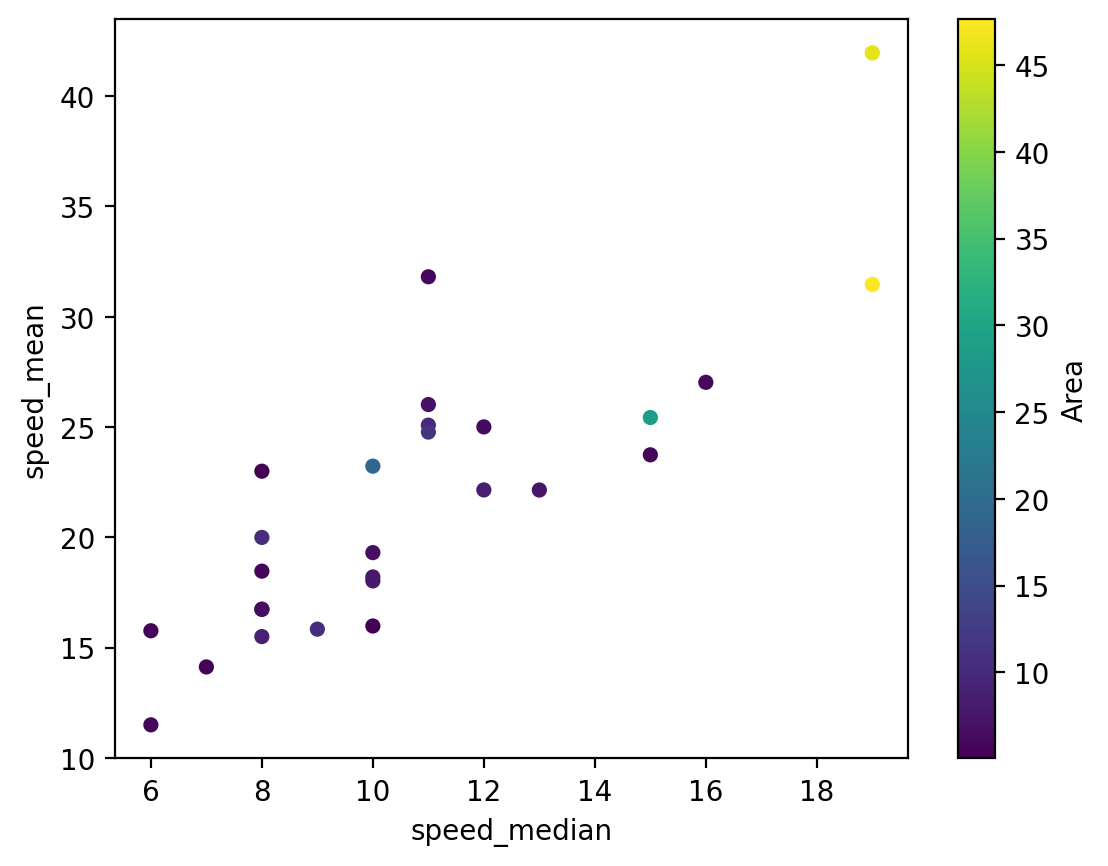

In [179]:
fig, ax = plt.subplots()
sc = rgi_itslive.plot.scatter(x='speed_median',y = 'speed_mean', c = 'Area', ax=ax)

Now we have a plot but there is still more information we'd like to include. For example, the labelling could be improved to show units. Changing the x-axis and y-axis labels of the pandas dataframe plot is pretty simple: 

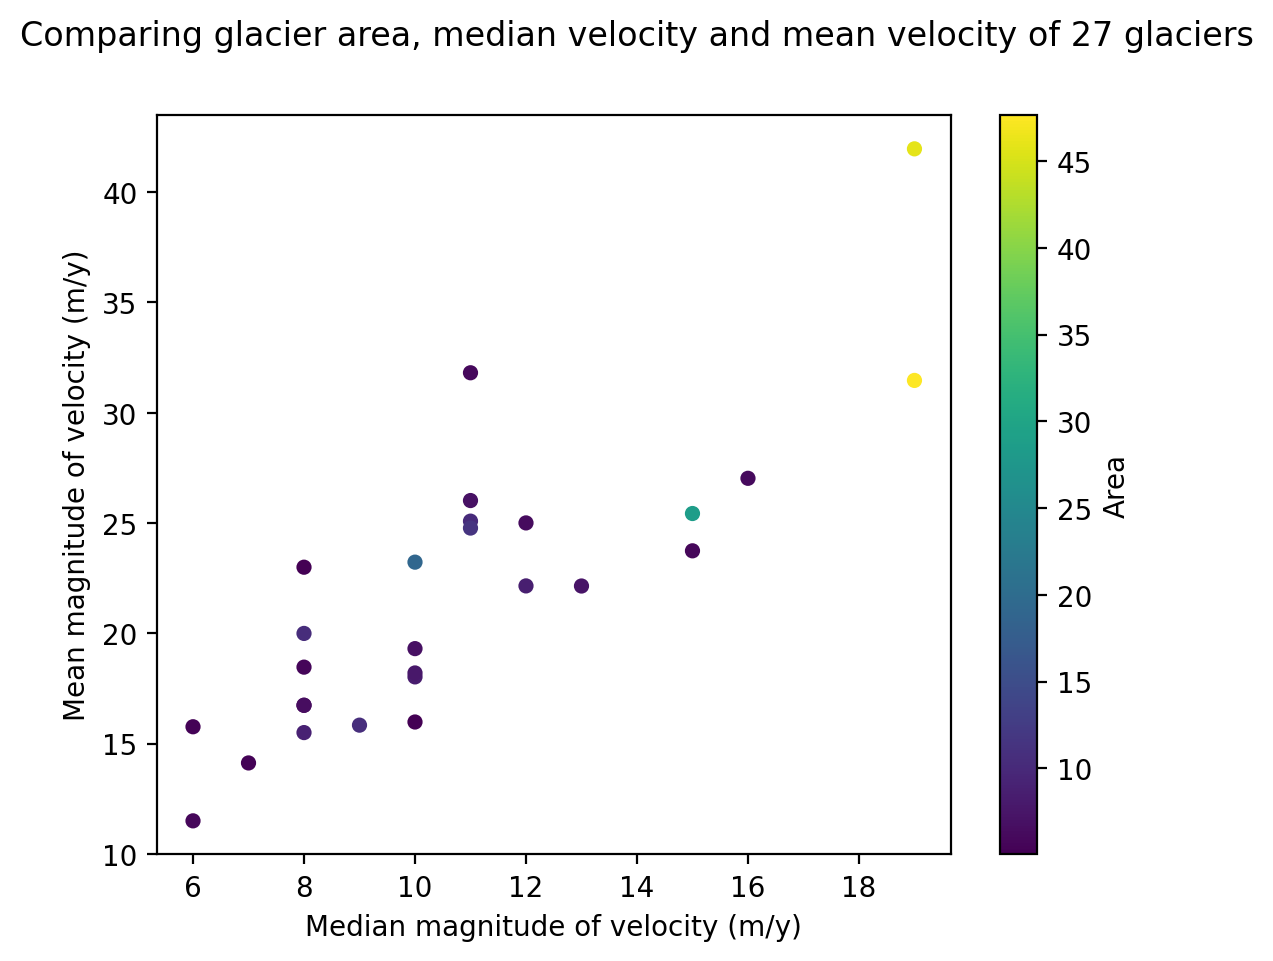

In [180]:
fig, ax = plt.subplots()
sc = rgi_itslive.plot.scatter(x='speed_median',y = 'speed_mean', c = 'Area', ax=ax)#.legend({'label':'test'})

fig.suptitle('Comparing glacier area, median velocity and mean velocity of 27 glaciers');
ax.set_ylabel('Mean magnitude of velocity (m/y)')
ax.set_xlabel('Median magnitude of velocity (m/y)');



But this could still be improved. The Colormap that describes the area variable in this plot would be more descriptive if it included units. 
Here is one way of editing the Colormap label:

In [181]:
#see what axes are in your fig object
fig.get_axes()

[<Axes: xlabel='Median magnitude of velocity (m/y)', ylabel='Mean magnitude of velocity (m/y)'>,
 <Axes: label='<colorbar>', ylabel='Area'>]

In [183]:
#extract the one we are interested in (colorbar)
cax = fig.get_axes()[1]
cax

<Axes: label='<colorbar>', ylabel='Area'>

In [184]:
#modify colorbar label
cax.set_ylabel('Area (sqare kilometer)')

Text(1102.9030555555557, 0.5, 'Area (sqare kilometer)')

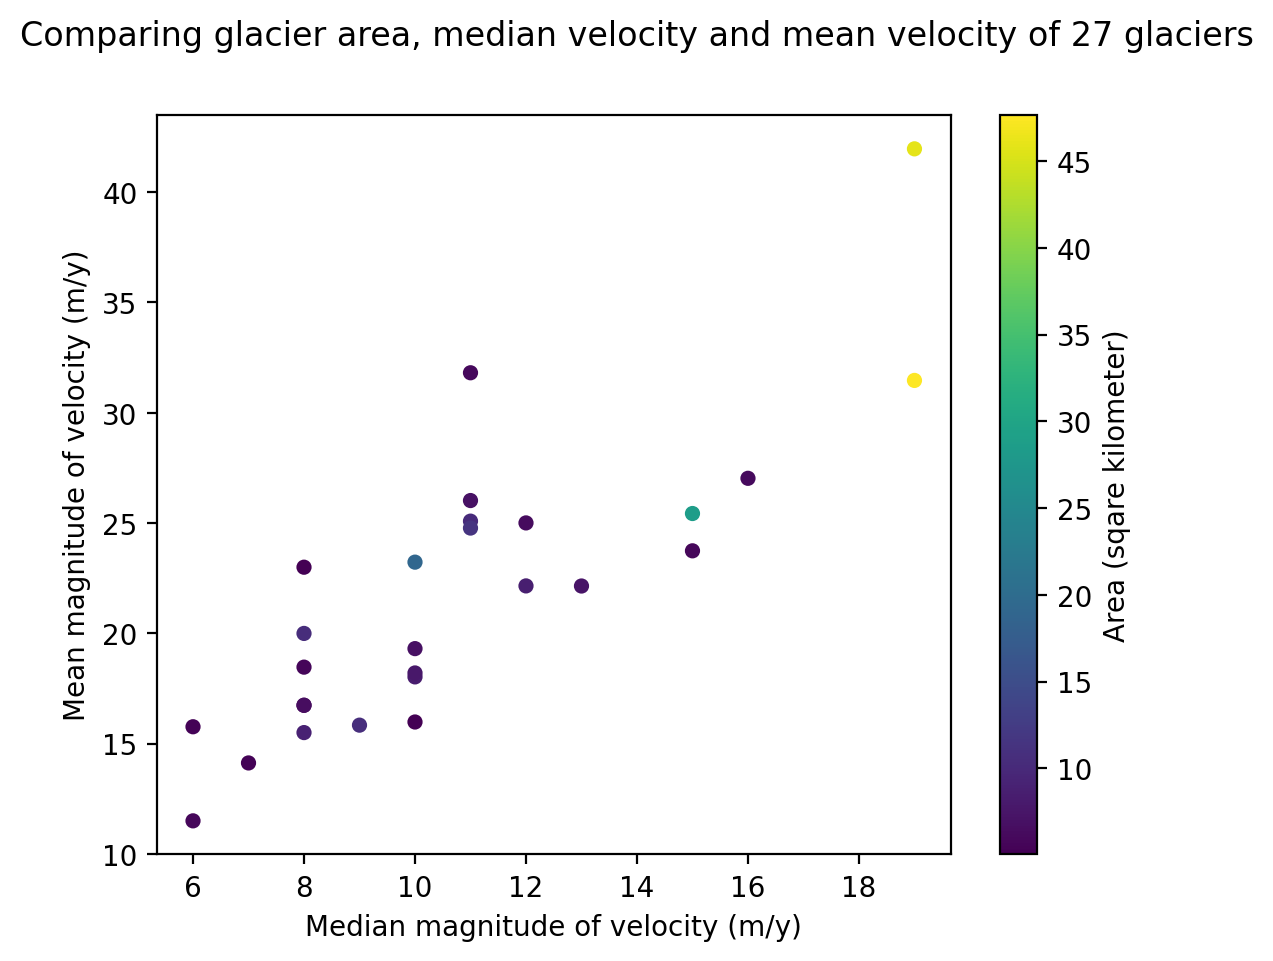

In [186]:
#all together
fig, ax = plt.subplots()
sc = rgi_itslive.plot.scatter(x='speed_median',y = 'speed_mean', c = 'Area', ax=ax)#.legend({'label':'test'})

fig.suptitle('Comparing glacier area, median velocity and mean velocity of 27 glaciers');
ax.set_ylabel('Mean magnitude of velocity (m/y)')
ax.set_xlabel('Median magnitude of velocity (m/y)');

cax = fig.get_axes()[1]
cax.set_ylabel('Area (sqare kilometer)');


### Geopandas plotting

In these plots, we are using the geometry information stored in the Geopandas.GeoDataFrame.

#### Static plots

Specify the variable you'd like to observe in the plot. Set `legend=True` to add the colormap and pass `legend_kwds` as a dictionary to change the label and set other characteristics of the legend object.

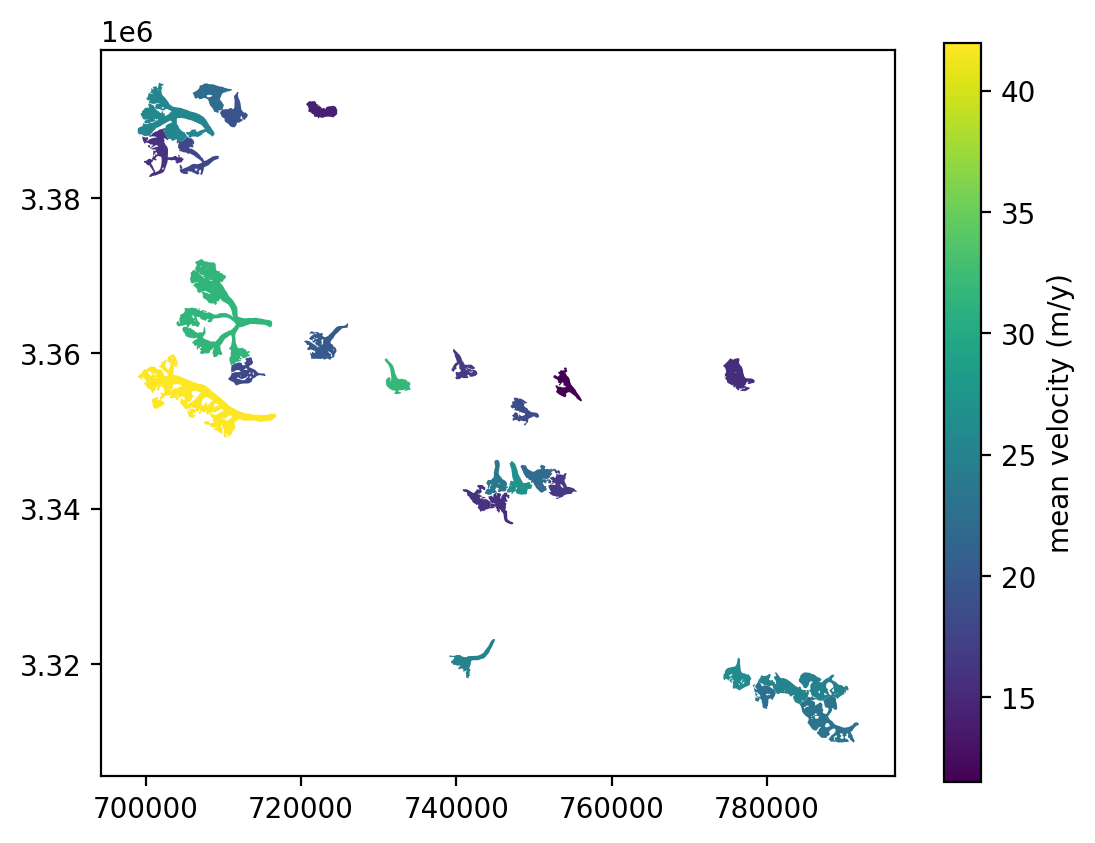

In [157]:
fig, ax = plt.subplots()
rgi_itslive.plot(ax=ax, column='speed_mean', legend=True,     
                 legend_kwds={"label": "mean velocity (m/y)", "orientation": "vertical"},);

#### Interactive plots 

The `geopandas.explore()` method returns an interactive map of a Geopandas.GeoDataFrame - cool! 

In [187]:
rgi_itslive.explore()

We can further customize the interactive plot:

In [202]:
rgi_itslive.explore('speed_median', cmap='inferno', style_kwds={'fillOpacity':0.7, 'stroke':False}, #stroke removes border around polygons, fillOpactiy sets opacity of polygons
                                                   )

Awesome! We have encoded vector data onto a raster object that let's us examine raster data for multiple spatial units simultaneously and explore a number of ways to visualize this data.